# <span style="color:#296BCD">프로젝트 : </span> CIFAR-10 이미지 생성하기

#### 모듈 불러오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## <span style="color:#296BCD">1. 데이터셋 구성하기</span>

#### 1) 데이터셋 가져오기

In [2]:
cifar10 = tf.keras.datasets.cifar10

# 분류 문제와 달리 라벨 필요없기 때문에 train_y, test_y에 해당하는 데이터 무시
(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


train 데이터는 50000개, test 데이터는 10000개로 구성되어 있다.

#### 2) 이미지 정규화

In [3]:
# 각 이미지의 크기는 32x32, 픽셀은 0~255 사이의 정숫값을 가짐
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 각 픽셀을 [-1, 1]로 정규화시켜서 사용할 예정이므로
# 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠주기
train_image = train_x  # 시각화 위해 변수 따로 저장
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### 3) 데이터 시각화
<br>50000장 중에 랜덤으로 25장을 시각화해보자.

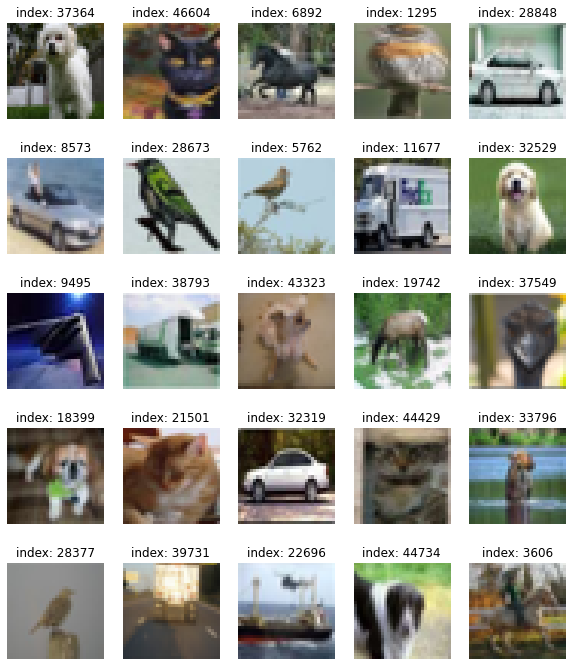

In [5]:
plt.figure(figsize=(10, 12))

for i in range(25):
    random_index = np.random.randint(1, 50000)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_image[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

#### 4) 미니배치 데이터셋 구성

In [6]:
BUFFER_SIZE = 50000   # 전체데이터를 섞기 위해 buffer size 50000으로 지정
BATCH_SIZE = 256  # 모델이 한 번에 학습할 데이터의 양

# from_tensor_slices() 함수 : 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_x라는 넘파이 배열형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

---

## <span style="color:#296BCD">2. 생성자(Generator) 모델 구현하기</span>

In [7]:
# 언제든 생성자를 생성할 수 있도록 만드는 함수

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,))) # 7*7*256=4096
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2)) # LeakyReLU의 alpha값에 0.2 부여

    # Second: Reshape layer  (이후의 Layer에서 Conv연산을 할 수 있도록 1차원 벡터를 (4, 4, 256)형상의 3차원 벡터로 변환시키는 층)
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
                                     # tanh : -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

Conv2DTranspose 층은 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다. (= DeConvolutional Layer)
<br> 이 모델에서는 네 번의 Conv2DTranspose 층을 이용해 (4, 4, 256) → (8, 8, 128) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나간다. 여기서 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일하다.



In [8]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용 출력

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 128)         0

In [9]:
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 만들기

noise = tf.random.normal([1, 100])

In [10]:
# 만들어진 생성자 모델에 입력값으로 노이즈 넣고 결과 이미지 생성해보기

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

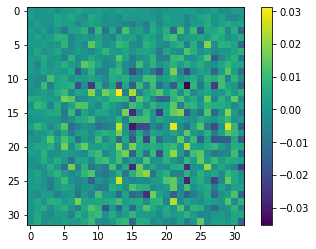

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

아직 모델이 전혀 학습하지 않은 상태이므로 아무 의미 없는 이미지가 생성되었다.

---

## <span style="color:#296BCD">3. 판별자(Discriminator) 모델 구현하기</span>

판별자는 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.
그렇다면 입력은 (32, 32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것이다.

In [12]:
# 판별자 모델을 생성하는 함수

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))   # LeakyReLU의 alpha값에 0.2 부여
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다. 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 된다.

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환한다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 된다.

In [13]:
# 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용 출력

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [14]:
# 아까 생성했던 가짜 이미지를 판별자에 입력시켜보기

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00274124]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었다. 이 값 또한 아직은 아무런 의미가 없는 값일 것이다.

---

## <span style="color:#296BCD">4. 손실함수, 정확도함수, 최적화함수 설정</span>

#### 1) 손실함수 (Loss)

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.
<br> 이진 분류이니 binary cross entropy를 사용할 것이다.
- from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산한다.

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
# <생성자의 손실함수>
# fake_output이 1에 가까워져야 손실이 작아짐
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# <판별자의 손실함수>
# fake_output은 0에 가까워지고, real_output이 1에 가까워져야 손실이 작아짐
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### 2) 정확도 함수 (Accuracy)

판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [17]:
# <판별자의 정확도 함수>
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

- (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
- (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
- (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5


#### 3) 최적화 함수 (Optimizer)

최적화 기법 중 Adam을 선택하고, 중요한 하이퍼파라미커인 learning rate는 0.0001로 설정할 것이다.

In [18]:
# <생성자의 최적화 함수>
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# <판별자의 최적화 함수>
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
                            # beta_1 은 이전 결과가 영향을 주는 정도

#### 4) 고정 seed 노이즈 샘플 만들어두기

매번 학습이 진행될 동안 생성자가 생성한 샘플에 대해 진전 과정을 확인하기 위한 고정된 seed 노이즈, 100차원의 16개 노이즈를 만든다.

In [19]:
noise_dim = 100
num_examples_to_generate = 16

tf.random.set_seed(2)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---

## <span style="color:#296BCD">5. 훈련과정 상세 기능 구현하기</span>

#### 1) 미니배치 훈련 함수 : train_step()
<br> 1개 미니배치의 훈련 과정을 처리하는 함수를 구현해보자.
<br> @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환된다.
- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [20]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 2) 이미지 시각화 함수 : generate_and_save_images()

16개의 고정된 seed를 입력받아서 훈련과정을 거치며 생성된 샘플 이미지들을 시각화 하는 함수를 구현해보자.

In [21]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        np_predictions = predictions.numpy()  # 역정규화를 위해 numpy로 변경
        np_predictions = (np_predictions * 127.5) + 127.5  # 원본이미지처럼 [0, 255]로 스케일링 (reverse of normalization)
        np_predictions = np_predictions.astype(int)
        plt.subplot(4, 4, i+1)
        plt.imshow(np_predictions[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

#### 3) History 시각화 함수 : draw_train_history()
train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어보자.

In [22]:
rcParams['figure.figsize'] = 18, 10    # matlab 차트의 기본 크기를 18,10으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### 4) Checkpoint 모듈
training_checkpoints 디렉토리에 몇 epoch마다 정기적으로 모델을 저장하는 checkpoint 모듈을 설정한다.
<br>
- tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장한다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장한다.

In [23]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---

## <span style="color:#296BCD">6. 학습 과정 진행하기</span>

#### 1) 모델 학습 함수 만들기

In [24]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

#### 2) 하이퍼파라미터 지정

In [25]:
save_every = 5  # 모델을 저장하는 간격
EPOCHS = 300  # 300 epochs로 시작

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 3) 학습 진행하기

학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
진행 과정을 수시로 확인해야한다.

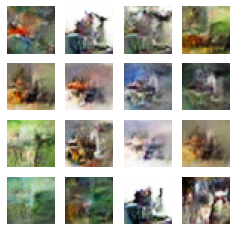

Time for training : 5074 sec


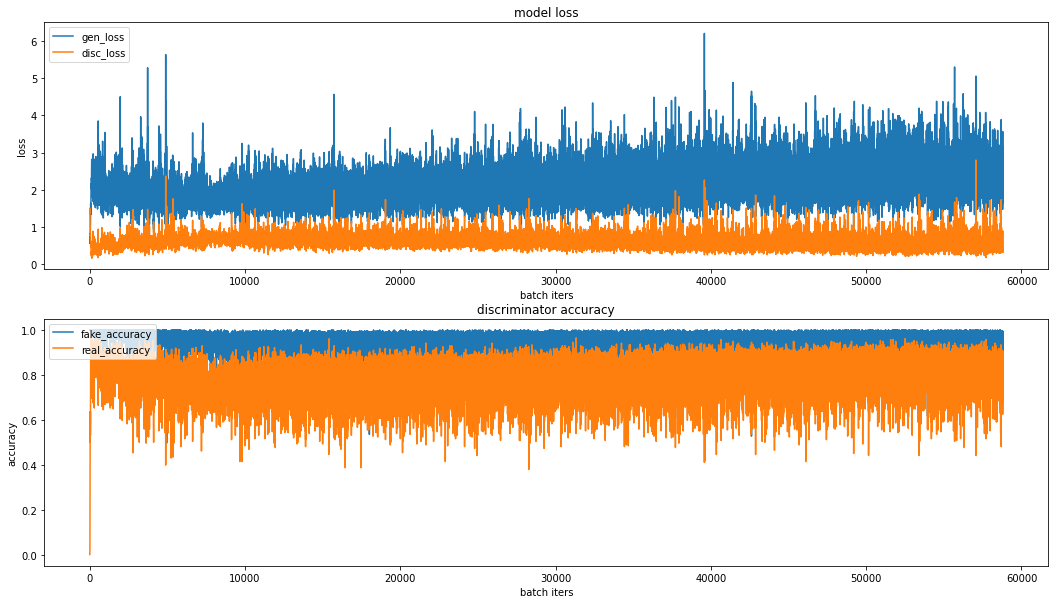

CPU times: user 1h 26min 51s, sys: 7min 50s, total: 1h 34min 41s
Wall time: 1h 24min 38s


In [26]:
%%time
train(train_dataset, EPOCHS, save_every)

#### 4) 학습 과정 시각화하기
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해보자.
<br> GIF 파일은 imageio 라이브러리를 활용해 만들 수 있다. imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식이다.

In [27]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2323935 Feb 14 03:45 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


---

## <span style="color:#296BCD">7. 체크포인트에서 모델 불러와서 추가 학습 시키기</span>

#### 1) 300 epochs 추가 (총 600 epochs)

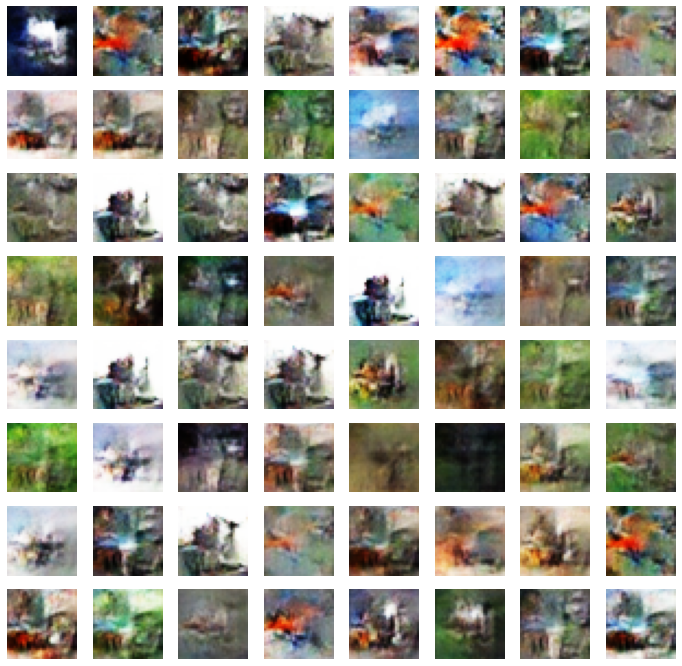

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인 
plt.figure(figsize=(12, 12))

for i in range(64):
    plt.subplot(8, 8, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
    
plt.show() # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

추가로 300 epochs을 더 돌려보겠다.

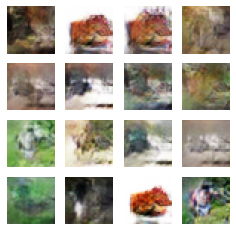

Time for training : 5141 sec


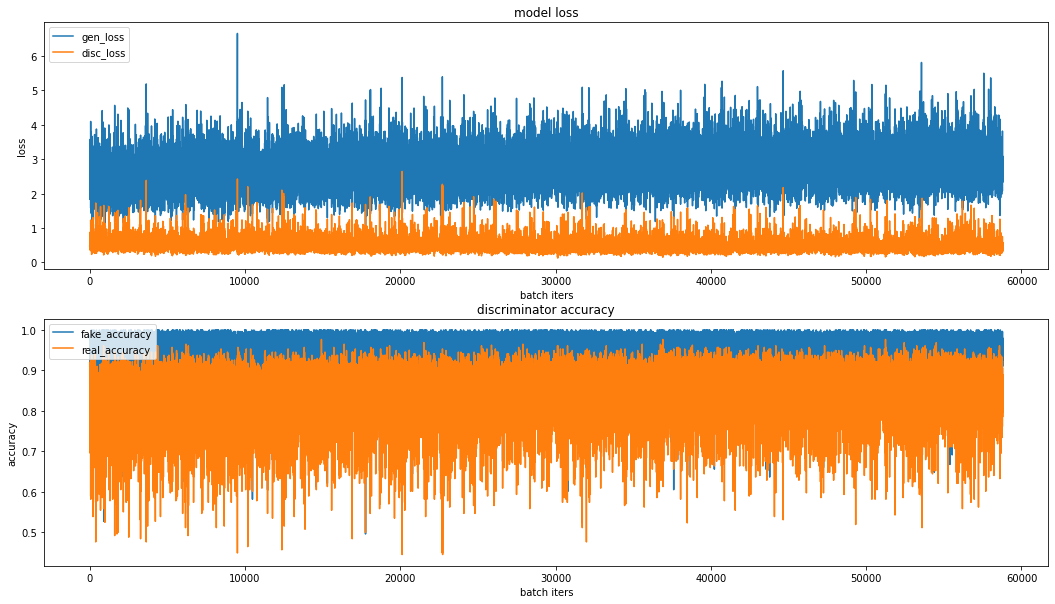

CPU times: user 1h 27min 56s, sys: 7min 48s, total: 1h 35min 44s
Wall time: 1h 25min 45s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif

-rw-r--r-- 1 root root 2246798 Feb 14 05:11 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif


#### 2) 300 epochs 또 추가 (총 900 epochs)

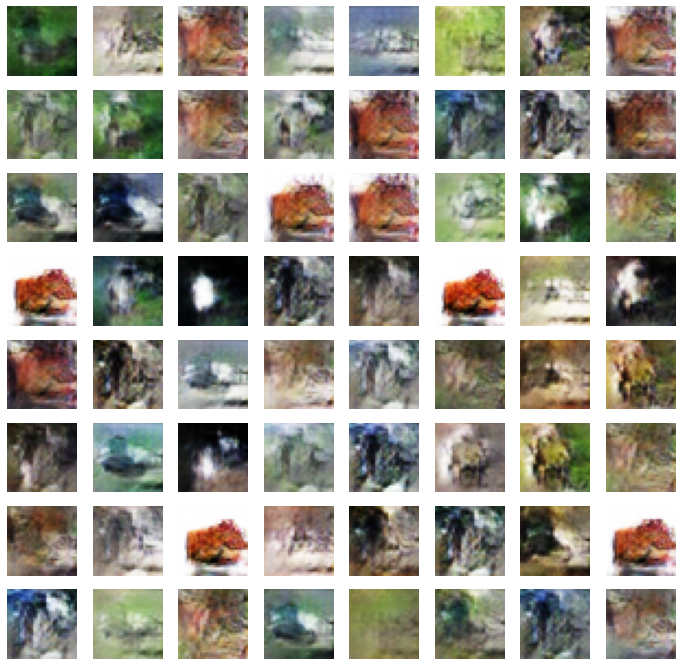

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인 
plt.figure(figsize=(12, 12))

for i in range(64):
    plt.subplot(8, 8, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
    
plt.show() # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

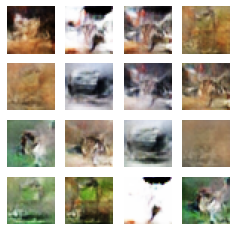

Time for training : 5151 sec


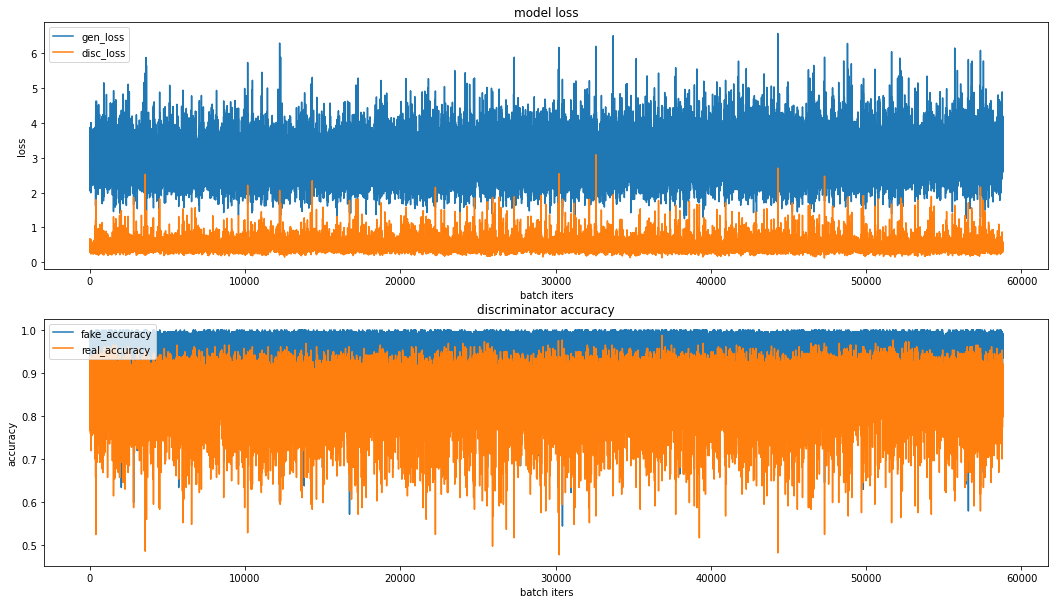

CPU times: user 1h 28min 6s, sys: 7min 48s, total: 1h 35min 54s
Wall time: 1h 25min 55s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif

-rw-r--r-- 1 root root 2191250 Feb 14 06:37 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif


#### 3) 300 epochs 또 추가 (총 1200 epochs)

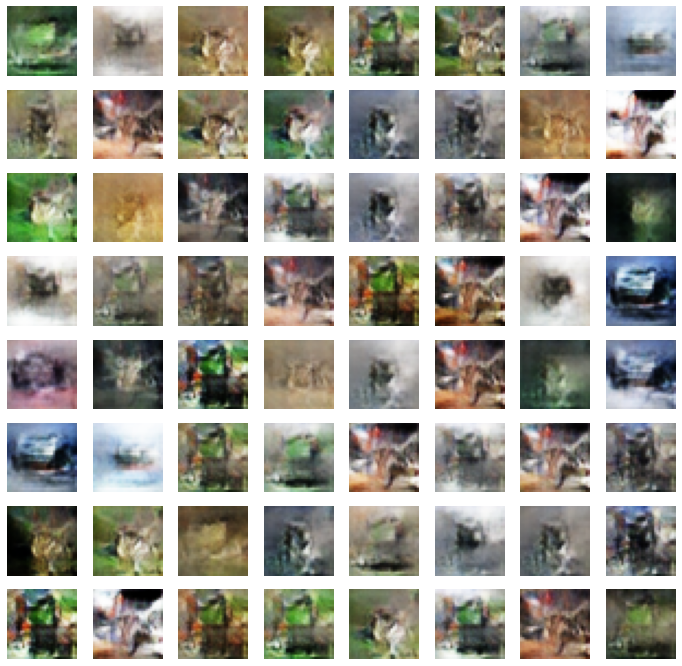

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인 
plt.figure(figsize=(12, 12))

for i in range(64):
    plt.subplot(8, 8, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
    
plt.show() # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

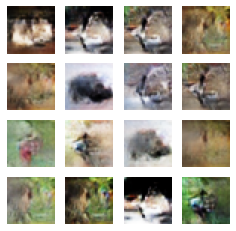

Time for training : 5119 sec


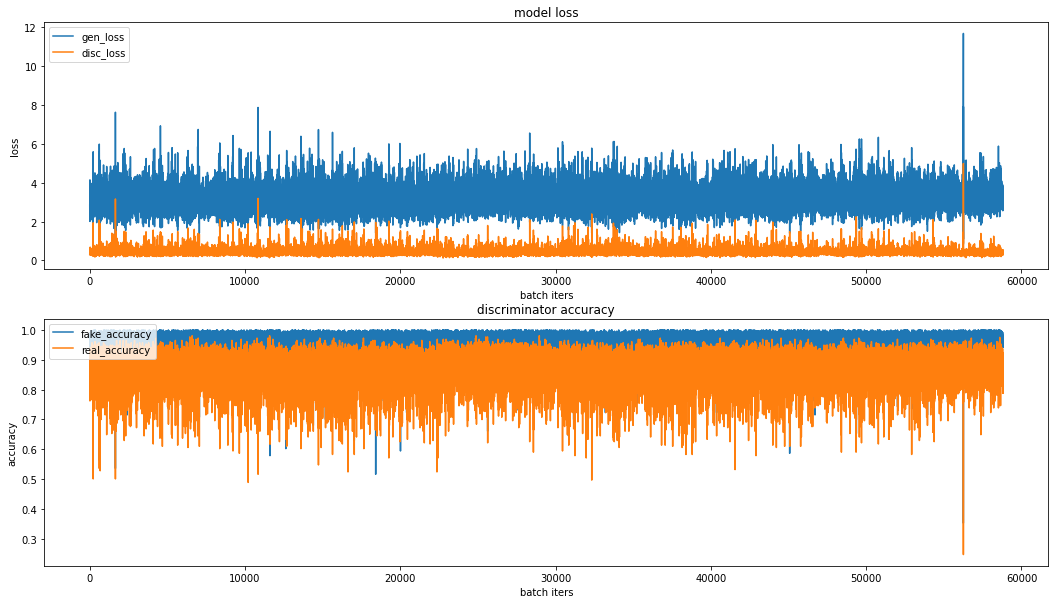

CPU times: user 1h 27min 30s, sys: 7min 49s, total: 1h 35min 20s
Wall time: 1h 25min 23s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

In [36]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif

-rw-r--r-- 1 root root 2224658 Feb 14 08:31 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif


---

## <span style="color:#296BCD">8. 학습 진행에 따른 결과</span>

| 첫 300 epochs | 600 epochs | 900 epochs | 1200 epochs|
| :---: | :---: | :---: | :---:|
|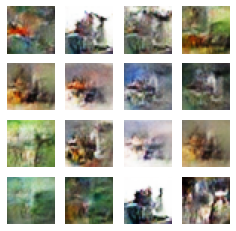| 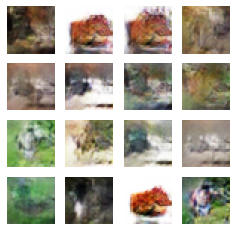| 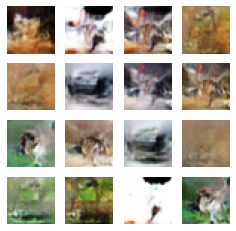| 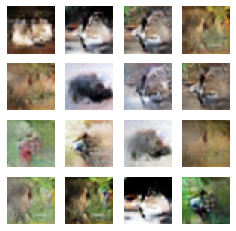|

처음 300 epochs만 돌렸을 때보다 1200 epochs 돌렸을 때는 좀 더 희미하거나 번지는 형태가 덜해지긴 했다. 
<br> 600 epochs까지는 뭔가 형체를 알아볼 수 없는 이미지들이 생성되었지만, 900 epochs까지 돌려봤을 때 개구리나 새 같은 형체가 약간 알아볼 수 있을 정도로 나타나기 시작했다. <br> 1200 epochs까지 돌리니 동물의 얼굴 형태가 나오고 동물의 몸 윤곽도 나온 것 같지만, 사실 이것도 잘 나온 것이라고 보기는 힘들다.
<br> 희한한 것은 대체적으로 동물의 형태만 등장하는 것 같다. 기존 CIFAR10의 데이터셋의 클래스는 (비행기, 자동차, 배, 트럭), (새, 고양이, 사슴, 개, 개구리, 말) 이렇게 교통수단과 동물로 나뉘는데, 교통수단과 비슷한 이미지는 하나도 없다. 아무래도 그들의 형태도 동물과 비슷하다고 인식하는 모양이다. 이게 다 모델 설정과 학습 시간에서의 아쉬움의 결과이다.

번외로 1200 epochs의 결과물을 좀더 자세히 살펴봤는데, 위 그림의 (3,2)그림은 개의 얼굴이 명확히 보인다. 몸이 묘사되지 못한 것이 좀 아쉽다. (3,3)그림은 다른 종류의 개와 비슷한 형태인데, 약간 비버를 닮은 것 같기도 하다. (4,2)와 (4,4)의 그림은 900 epochs까지는 분명 새의 형태였는데, 1200 epochs까지 돌리니 무언가 다른 것이 합성된 듯하면서 형체가 이상해졌다. 특히 (4,4)는 새의 색깔을 띄면서 고양이의 얼굴 형태와 사슴의 무늬를 가진 해괴한 동물이 등장한 것 같다.

| 첫 300 epochs | 600 epochs | 900 epochs | 1200 epochs |
| :---: | :---: | :---: | :---: |
| <img src="./cifar10_dcgan.gif"> | <img src="./cifar10_dcgan1.gif"> | <img src="./cifar10_dcgan2.gif"> | <img src="./cifar10_dcgan3.gif"> |

---

# <span style="color:#296BCD">회고</span>

#### 프로젝트 과정

- **데이터 시각화 관련** <br>
처음에 데이터셋을 구성하는 단계에서 이미지 정규화를 해주고 시각화를 해주었을 때 이미지가 어둡게 나오면서 "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers"라는 오류메세지가 같이 떴다. imshow는 RGB 데이터가 0~1 또는 0~255 사이의 정수값을 가지고 있어야 제대로 시각화를 할 수 있는데, 이미지를 -1~1 사이로 정규화를 해줬기 때문에 오류가 난 것이었다. 처음 과정에서는 어떻게 이것을 해결해야 할 지 몰라서 우선 정규화를 시키지 않은 이미지 데이터 변수를 따로 저장하여 그것으로 시각화를 해주었다. 후에 노드를 진행하면서 이미지를 역정규화하는 방법이 등장해서, 구글링으로 확실히 알아본 다음에 이미지 시각화 함수 구현 과정에서 역정규화를 시행해주었더니 이미지 시각화 과정에서 어둡게 나오는 일은 없어졌다.
<br><br>
- **생성자 모델 구현 과정** <br>
생성자 모델을 만드는 과정에서 처음에 좀 헤맸다. 바로 직전 패션 MNIST로 실습할 때 썼던 흑백 데이터보다 CIFAR10의 칼라 데이터는 채널이 많아져서 모델을 더 깊고 정교하게 만들어야 하는데, 그 정도를 찾기가 좀 어려웠던 것 같다. 조금만 쌓자니 학습이 제대로 되지 않아서 이상한 결과가 나올까봐 두려웠고, 많이 추가하자니 학습시간이 너무 오래 걸릴까봐 걱정이 되었다. 그래서 소심하게 Conv2DTranspose layer를 하나만 더 추가해주었다. 결과적으로 좀 아쉬운 선택이 되었던 것이, 학습 과정을 통해 원하는 결과를 얻지 못한 것 같아서 생성자 모델을 처음부터 많이 쌓지 못한 것이 후회가 되었다. 대신 활성화함수 LeakyReLU의 alpha 값을 0.2로 두고 학습에 좀 더 도움이 될 수 있게 해주었다.
<br><br>
- **판별자 모델 구현 과정** <br>
판별자를 더 깊게 쌓으면 판별자가 너무 똑똑해져서 생성자가 가야할 길을 잃어버릴 것 같고, 판별자 모델을 더 얕게 쌓으면 생성자에게 피드백을 제대로 주지 못할 것 같아서 그냥 실습과정 때와 똑같이 만들고 역시 LeakyReLU의 alpha값에 0.2를 부여하기만 했다. 생성자 모델을 쌓을 때도 그렇고 계속 Trade-off의 고민이 생기는 것 같다. 어느 정도가 적당한 선인지 초기에 설정하는 것이 너무 어려웠다. 나중에 시간 상 여건이 될 때 모델을 여러 개 만들어서 실험을 해볼 필요성을 절실히 느꼈다.
<br><br>
- **최적화 함수 설정 과정**<br>
cs231n에서 최적화 함수 Adam에 대해 공부한 것을 토대로 beta1값을 0.5로 설정했다. 판별자 모델의 fake_accuracy와 real_accuracy의 목표를 1이 아닌 0.5로 하려면 판별자가 너무 똑똑해선 안되고 생성자에게 속아야 한다. 생성자가 계속 생성해내는 이미지에 대해 이전의 결과가 영향을 덜 미치게끔 하려면 기존의 가중치가 아닌 새롭게 계산한 가중치의 비중을 더 높여야 했다. 결과적으로 좋은 선택인지는 역시 이미지 결과가 애매모호했기 때문에 잘 모르겠다. 다음에 실험할 때 꼭 변경해볼 필요가 있다.
<br><br>
- **고정 seed 노이즈 설정 과정**<br>
생성자가 생성한 샘플을 확인하기 위해 16개의 노이즈를 설정할 때, 완벽하게 고정된 seed를 만들어주려면 동일한 난수를 생성할 수 있게 tf.random.set_seed()를 추가해주어야 한다. [참고링크](https://junstar92.tistory.com/98)
<br><br>
- **훈련과정 상세 기능 구현 과정**<br>
데코레이터 기능에 대해 숙지가 안되어있어서 미니배치 훈련 함수를 만들 때 데코레이터 쓰는 것에 대해 이해하는 데에 시간이 좀 걸렸다. 사실 이 프로젝트에서는 그렇게 자세하게 알아야할 정도보다는 학습을 수월하게 해주게 하기 위한 설정일 뿐이었지만, 이번 기회에 데코레이터에 대해 다시 공부하고 이해했다. 생각보다 많이 쓰이고 있었고, 앞으로 좀더 공부하고 숙지해서 다음에 나올 때 코드 이해에 좀더 도움이 될 수 있도록 해야겠다.
<br><br>
- **Epochs 설정에 대해**<br>
처음에 단순하게 100epochs 정도면 되겠지라는 생각으로 모델을 돌렸는데, 터무니 없었다. 그래서 다시 처음부터 시작해서 200epochs을 돌려보았는데, 마찬가지로 별로 나아진 것이 없었다. 그래서 다시 300번을 돌리고 추가로 1200epochs까지 해주게 되었는데, 앞으로 초기 epochs에 대한 감을 좀더 잡아야할 것 같다. 

#### 어렵고 아쉬운 점


- 점점 갈수록 프로젝트가 어려워지고 있다. 이번엔 GAN이라는 처음 보는 생성모델이 등장해서 개념을 공부하는 데에도 시간이 좀 걸렸다.
<br> 코드를 이해하는 데에도 마찬가지로 시간이 걸려서 프로젝트를 시작하기까지 오래걸렸던 것 같다.
<br> 너무 아쉬웠던 한 가지는, 커널 시간이 한정되어 있어서 학습을 더 오래 돌리고 싶어도 돌리지 못했다는 점이다. 오래 걸릴 것 같아서 코드를 실행해놓고 잤는데 다음날 아침에 커널이 만료되어 있어서, 실행했던 코드들을 다시 한번 처음부터 다 돌리는 일이 생겼다. 그렇게 다시 돌려서 쭉 1200epochs까지 실행했는데, 다른 노드를 보기 위해 잠깐 커널을 바꾼 것이 큰 실수였다. 커널이 또 다시 만료되어서 더 시도해보고 싶은게 있어도 못하게 되었다. 이럴거면 체크포인트는 왜 설정했는지, 커널이 한정되어있는 상태에서 체크포인트는 아무 쓸모가 없는 것 같다. 다음 기회에 로컬에서 체크포인트를 다시 써봐야겠다.
<br><br>
- 1200 epochs까지 돌렸는데, 이상하게 fake_accuracy와 real_accuracy가 줄어드는 형태를 볼 수가 없었다. 또 Loss 값도 계속 똑같이 유지되는 것 같았다. 물론 학습을 진행할수록 accuracy가 0.5 밑으로 내려오는 때도 종종 보였지만 전체적으로 그래프를 보면 줄어들고 있지 않았다. 아마도 앞에서 언급했듯 내가 생성자와 판별자 모델을 잘못 설정한 것 같다. generator를 좀더 깊게 많이 쌓고, 학습 파라미터의 수도 늘렸어야 했는데 학습시간이 무서워서 추가적으로 쌓지를 못했다. 그래서 이미지에 대한 결과도 약간 아리송하게 나온 것 같다. 모델을 제대로 깊고 똑똑하게 만들고, epochs 수도 늘리면 정교한 실제 같은 이미지가 진짜 나오는지 매우 궁금하다.
<br><br>
- 이번 노드의 최대 장애물은 학습시간이었다. 나는 300epochs씩 돌릴때마다 2시간이 조금 안되게 걸렸는데도 너무 길다고 생각했다. 배정된 커널 혹은 클라우드에 따라서 시간이 천차만별인 것 같은데, 제대로 된 결과물을 나오게 하려면 커널이 오랫동안 유지되는 환경에서 학습시간을 정말 길게 잡고 며칠을 돌려봐야 하는 것 같다.
<br><br>
- CIFAR10을 학습시켜서 CIFAR10과 비슷한 이미지를 생성하는 것 자체가 좀 재미가 덜했다. 패션 MNIST로 옷의 형태를 만드는 과정이 훨씬 낫다고 생각했다. 생성 모델을 공부한다고 해서 기대했는데 데이터셋과 결과물이 개인적으로는 흥미가 좀 떨어지는 것 같다. 사람 얼굴을 생성해내거나, 예쁜 디자인 혹은 더 재밌는 종류의 것들을 적용하면 더 열정적으로 모델에 대해 공부해볼 수 있을 것 같다.

#### 다음에..
- 생성자 모델을 좀더 정교하고 깊게 만들고, 파라미터들을 조정해보기
- 판별자 모델이 생성자 모델에게 피드백을 더 잘 줄 수 있도록 고안해보기
- 학습시간을 길게 잡고 Epochs을 더 많이 돌려보기
- CIFAR10이 아닌 다른 데이터셋을 통해 더 재밌는 이미지 생성해내기
- DCGAN 뿐만 아니라 AUTOENCODER에 대해서도 공부해보기